In [ ]:
# Activate Virtual Environment and Install Requirements
#!python3 -m venv ../brain_model_env
#!source ../brain_model_env/bin/activate
#!python3 -m ipykernel install --user --name=brain_model_env --display-name "Python (brain_model_env)"
#remember to switch to notebook/virtual environment kernel

In [10]:
from dp_model.model_files.sfcn import SFCN
from dp_model import dp_loss as dpl
from dp_model import dp_utils as dpu
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import nibabel as nib
from tqdm import tqdm

# Sex Prediction Test on ABIDEI (0 F 1 M)

In [8]:
# -----------------------
# Settings
# -----------------------
input_root = '../ABIDE_Dataset/data/Cropped/ABIDEI'  # Root folder with sub-xxxx/anat/*.nii.gz
participants_path = '../ABIDE_Dataset/data/ABIDEI/participants.tsv'
model_weights_path = './sex_prediction/run_20191008_00_epoch_last.p'
label_column = 'sex'  # or whatever your ground truth column is

# -----------------------
# Load model
# -----------------------
model = SFCN(output_dim=2, channel_number=[28, 58, 128, 256, 256, 64])
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_weights_path, weights_only=True))
model.cuda()
model.eval()

# -----------------------
# Load labels
# -----------------------
df = pd.read_csv(participants_path, sep='\t')
df['participant_id'] = df['participant_id'].str.strip()
df = df.set_index('participant_id')

# -----------------------
# Inference loop
# -----------------------
records = []
correct = 0
total = 0

# Loop through subject subfolders
for subject_id in tqdm(sorted(os.listdir(input_root))):
    if not subject_id.startswith('sub-'):
        continue

    # Full path to T1w file
    anat_dir = os.path.join(input_root, subject_id, 'anat')
    if not os.path.isdir(anat_dir):
        continue

    # Find the T1w NIfTI file (assuming one per subject)
    nii_files = [f for f in os.listdir(anat_dir) if f.endswith('.nii.gz')]
    t1w_file = None
    for f in nii_files:
        if subject_id in f and 'T1w' in f:
            t1w_file = f
            break

    if t1w_file is None:
        print(f"No T1w file found for {subject_id}")
        continue

    full_path = os.path.join(anat_dir, t1w_file)

    if subject_id not in df.index:
        print(f"{subject_id} not in participants.tsv")
        continue

    true_label = df.loc[subject_id, label_column]

    # Load and normalize
    data = nib.load(full_path).get_fdata()
    data = data / data.mean()

    # Prepare input tensor (1, 1, D, H, W)
    input_tensor = torch.tensor(data.reshape((1,) + data.shape), dtype=torch.float32).cuda()

    # Run model
    with torch.no_grad():
        output = model(input_tensor)
        probs = output[0].cpu().reshape([1, -1])
        probs = np.exp(probs.numpy().reshape(-1))

        
    pred_label = np.argmax(probs)
    is_correct = int(pred_label == true_label)

    correct += is_correct
    total += 1

    records.append({
        'subject_id': subject_id,
        'true_label': true_label,
        'predicted_label': pred_label,
        'prob_female': probs[0],
        'prob_male': probs[1],
        'correct': is_correct
    })

# -----------------------
# Save and report
# -----------------------
results_df = pd.DataFrame(records)
results_df.to_csv('../ABIDE_Dataset/outputs/ABIDEI/sfcn_sex_predictions.csv', index=False)

accuracy = correct / total if total > 0 else 0
print(f"\nFinished inference on {total} subjects")
print(f"Accuracy: {accuracy:.2%}")


100%|██████████| 985/985 [02:33<00:00,  6.41it/s]


Finished inference on 985 subjects
Accuracy: 84.16%


# Sex Prediction Test on ABIDEII (0 F 1 M)

In [9]:
# -----------------------
# Settings
# -----------------------
input_root = '../ABIDE_Dataset/data/Cropped/ABIDEII'  # Root folder with sub-xxxx/anat/*.nii.gz
participants_path = '../ABIDE_Dataset/data/ABIDEII/participants.tsv'
model_weights_path = './sex_prediction/run_20191008_00_epoch_last.p'
label_column = 'sex'  # or whatever your ground truth column is

# -----------------------
# Load model
# -----------------------
model = SFCN(output_dim=2, channel_number=[28, 58, 128, 256, 256, 64])
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_weights_path, weights_only=True))
model.cuda()
model.eval()

# -----------------------
# Load labels
# -----------------------
df = pd.read_csv(participants_path, sep='\t')
df['participant_id'] = df['participant_id'].str.strip()
df = df.set_index('participant_id')

# -----------------------
# Inference loop
# -----------------------
records = []
correct = 0
total = 0

# Loop through subject subfolders
for subject_id in tqdm(sorted(os.listdir(input_root))):
    if not subject_id.startswith('sub-'):
        continue

    # Full path to T1w file
    anat_dir = os.path.join(input_root, subject_id, 'anat')
    if not os.path.isdir(anat_dir):
        continue

    # Find the T1w NIfTI file (assuming one per subject)
    nii_files = [f for f in os.listdir(anat_dir) if f.endswith('.nii.gz')]
    t1w_file = None
    for f in nii_files:
        if subject_id in f and 'T1w' in f:
            t1w_file = f
            break

    if t1w_file is None:
        print(f"No T1w file found for {subject_id}")
        continue

    full_path = os.path.join(anat_dir, t1w_file)

    if subject_id not in df.index:
        print(f"{subject_id} not in participants.tsv")
        continue

    true_label = df.loc[subject_id, label_column]

    # Load and normalize
    data = nib.load(full_path).get_fdata()
    data = data / data.mean()

    # Prepare input tensor (1, 1, D, H, W)
    input_tensor = torch.tensor(data.reshape((1,) + data.shape), dtype=torch.float32).cuda()

    # Run model
    with torch.no_grad():
        output = model(input_tensor)
        probs = output[0].cpu().reshape([1, -1])
        probs = np.exp(probs.numpy().reshape(-1))

        
    pred_label = np.argmax(probs)
    is_correct = int(pred_label == true_label)

    correct += is_correct
    total += 1

    records.append({
        'subject_id': subject_id,
        'true_label': true_label,
        'predicted_label': pred_label,
        'prob_female': probs[0],
        'prob_male': probs[1],
        'correct': is_correct
    })

# -----------------------
# Save and report
# -----------------------
results_df = pd.DataFrame(records)
results_df.to_csv('../ABIDE_Dataset/outputs/ABIDEII/sfcn_sex_predictions.csv', index=False)

accuracy = correct / total if total > 0 else 0
print(f"\nFinished inference on {total} subjects")
print(f"Accuracy: {accuracy:.2%}")


 36%|███▌      | 346/960 [00:48<00:08, 68.51it/s]

sub-29057 not in participants.tsv
sub-29058 not in participants.tsv
sub-29059 not in participants.tsv
sub-29060 not in participants.tsv
sub-29062 not in participants.tsv
sub-29063 not in participants.tsv
sub-29064 not in participants.tsv
sub-29065 not in participants.tsv
sub-29066 not in participants.tsv
sub-29067 not in participants.tsv
sub-29068 not in participants.tsv
sub-29069 not in participants.tsv
sub-29070 not in participants.tsv
sub-29071 not in participants.tsv
sub-29072 not in participants.tsv
sub-29073 not in participants.tsv
sub-29074 not in participants.tsv
sub-29075 not in participants.tsv
sub-29076 not in participants.tsv
sub-29077 not in participants.tsv
sub-29078 not in participants.tsv
sub-29079 not in participants.tsv
sub-29080 not in participants.tsv
sub-29081 not in participants.tsv
sub-29082 not in participants.tsv
sub-29083 not in participants.tsv
sub-29085 not in participants.tsv
sub-29086 not in participants.tsv
sub-29087 not in participants.tsv
sub-29088 not 

100%|██████████| 960/960 [02:24<00:00,  6.66it/s]


Finished inference on 924 subjects
Accuracy: 75.32%


In [ ]:
# Just predicts 1 for everything

# Sex Prediction Test on ABIDEI (0 M 1 F)

In [25]:
# -----------------------
# Settings
# -----------------------
input_root = '../ABIDE_Dataset/data/Cropped/ABIDEI'  # Root folder with sub-xxxx/anat/*.nii.gz
participants_path = '../ABIDE_Dataset/data/ABIDEI/participants_sex_switch.tsv'
model_weights_path = './sex_prediction/run_20191008_00_epoch_last.p'
label_column = 'sex'  # or whatever your ground truth column is

# -----------------------
# Load model
# -----------------------
model = SFCN(output_dim=2, channel_number=[28, 58, 128, 256, 256, 64])
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_weights_path, weights_only=True))
model.cuda()
model.eval()

# -----------------------
# Load labels
# -----------------------
df = pd.read_csv(participants_path, sep='\t')
df['participant_id'] = df['participant_id'].str.strip()
df = df.set_index('participant_id')

# -----------------------
# Inference loop
# -----------------------
records = []
correct = 0
total = 0

# Loop through subject subfolders
for subject_id in tqdm(sorted(os.listdir(input_root))):
    if not subject_id.startswith('sub-'):
        continue

    # Full path to T1w file
    anat_dir = os.path.join(input_root, subject_id, 'anat')
    if not os.path.isdir(anat_dir):
        continue

    # Find the T1w NIfTI file (assuming one per subject)
    nii_files = [f for f in os.listdir(anat_dir) if f.endswith('.nii.gz')]
    t1w_file = None
    for f in nii_files:
        if subject_id in f and 'T1w' in f:
            t1w_file = f
            break

    if t1w_file is None:
        print(f"No T1w file found for {subject_id}")
        continue

    full_path = os.path.join(anat_dir, t1w_file)

    if subject_id not in df.index:
        print(f"{subject_id} not in participants.tsv")
        continue

    true_label = df.loc[subject_id, label_column]

    # Load and normalize
    data = nib.load(full_path).get_fdata()
    data = data / data.mean()

    # Prepare input tensor (1, 1, D, H, W)
    input_tensor = torch.tensor(data.reshape((1,) + data.shape), dtype=torch.float32).cuda()

    # Run model
    with torch.no_grad():
        output = model(input_tensor)
        probs = output[0].cpu().reshape([1, -1])
        probs = np.exp(probs.numpy().reshape(-1))

        
    pred_label = np.argmax(probs)
    is_correct = int(pred_label == true_label)

    correct += is_correct
    total += 1

    records.append({
        'subject_id': subject_id,
        'true_label': true_label,
        'predicted_label': pred_label,
        'prob_female': probs[0],
        'prob_male': probs[1],
        'correct': is_correct
    })

# -----------------------
# Save and report
# -----------------------
results_df = pd.DataFrame(records)
results_df.to_csv('../ABIDE_Dataset/outputs/ABIDEI/sfcn_sex_1F_predictions.csv', index=False)

accuracy = correct / total if total > 0 else 0
print(f"\nFinished inference on {total} subjects")
print(f"Accuracy: {accuracy:.2%}")


100%|██████████| 985/985 [02:33<00:00,  6.41it/s]



Finished inference on 985 subjects
Accuracy: 15.84%


In [ ]:
# Still just predicts 1 for everything

In [9]:
# Age Prediction

In [24]:
# ----------------------------
# Settings
# ----------------------------
image_root = "../ABIDE_Dataset/data/Cropped/ABIDEI"
participants_path = "../ABIDE_Dataset/data/ABIDEI/participants.tsv"
model_weights_path = "./brain_age/run_20190719_00_epoch_best_mae.p"
output_csv_path = "../ABIDE_Dataset/outputs/ABIDEI/sfcn_age_top1_predictions.csv"

bin_range = [0, 40]
bin_step = 1
sigma = 1
input_shape = (160, 192, 160)

# Compute bin centers
bin_centers = np.arange(bin_range[0], bin_range[1], bin_step)  # [0, 1, ..., 39]
num_bins = len(bin_centers)

# ----------------------------
# Load model
# ----------------------------
model = SFCN(output_dim=num_bins)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_weights_path, weights_only=True))
model.cuda()
model.eval()

# ----------------------------
# Load participants.tsv
# ----------------------------
df = pd.read_csv(participants_path, sep='\t')
df['participant_id'] = df['participant_id'].str.strip()
df = df.set_index('participant_id')

# ----------------------------
# Inference Loop
# ----------------------------
records = []
total_loss = 0
total_subjects = 0

for subject_id in tqdm(sorted(os.listdir(image_root))):
    if not subject_id.startswith('sub-'):
        continue

    anat_dir = os.path.join(image_root, subject_id, 'anat')
    if not os.path.isdir(anat_dir):
        continue

    nii_files = [f for f in os.listdir(anat_dir) if f.endswith('.nii') or f.endswith('.nii.gz')]
    t1w_file = next((f for f in nii_files if subject_id in f and 'T1w' in f), None)
    if t1w_file is None:
        print(f"No T1w file found for {subject_id}")
        continue

    if subject_id not in df.index or pd.isna(df.loc[subject_id, 'age']):
        print(f"{subject_id} missing age in participants.tsv")
        continue

    try:
        data = nib.load(os.path.join(anat_dir, t1w_file)).get_fdata()
    except Exception as e:
        print(f"Could not load {subject_id}: {e}")
        continue

    data = data / data.mean()

    # Crop (or skip if image too small)
    #if any(s < t for s, t in zip(data.shape, input_shape)):
        #print(f"{subject_id} image too small: {data.shape}")
        #continue

    input_tensor = torch.tensor(data.reshape((1,) + data.shape), dtype=torch.float32).cuda()

    # Soft label for KL loss
    age = df.loc[subject_id, 'age']
    y_soft, _ = dpu.num2vect([age], bin_range, bin_step, sigma)
    y_soft = torch.tensor(y_soft, dtype=torch.float32)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)  # [1, num_bins]
        logits = output[0].cpu()
        probs = torch.softmax(logits, dim=0).numpy()

        # Compute loss
        kl_loss = dpl.my_KLDivLoss(logits.unsqueeze(0), y_soft).item()

        # Top 2 predicted bins
        top2_idx = np.argsort(probs)[-2:][::-1]
        top2_probs = probs[top2_idx]
        top2_bins = bin_centers[top2_idx]

        records.append({
            'subject_id': subject_id,
            'true_age': age,
            'top1_class': top2_bins[0],
            'top1_prob': top2_probs[0],
            'kl_div_loss': kl_loss
        })

        total_loss += kl_loss
        total_subjects += 1

# ----------------------------
# Save and report
# ----------------------------
results_df = pd.DataFrame(records)
results_df.to_csv(output_csv_path, index=False)

avg_loss = total_loss / total_subjects if total_subjects > 0 else float('nan')
print(f"\nInference complete for {total_subjects} subjects")
print(f"Mean KL divergence loss: {avg_loss:.4f}")

100%|██████████| 985/985 [02:24<00:00,  6.83it/s]



Inference complete for 985 subjects
Mean KL divergence loss: 93.1585


In [26]:
# Example
# Note: the example model checkpoint works with UK Biobank T1_brain_linearto_MNI.nii.gz files
model = SFCN()
model = torch.nn.DataParallel(model)
fp_ = './brain_age/run_20190719_00_epoch_best_mae.p'
model.load_state_dict(torch.load(fp_, weights_only=True))
model.cuda()

# Example data: some random brain in the MNI152 1mm std space
image_path = "../ABIDE_Dataset/data/Cropped/ABIDEI/sub-0051291/anat/sub-0051291_T1w.nii.gz"
img = nib.load(image_path)
data = np.squeeze(img.get_fdata())
label = np.array([16.47,])

# Transforming the age to soft label (probability distribution)
bin_range = [0,40]
bin_step = 1
sigma = 1
y, bc = dpu.num2vect(label, bin_range, bin_step, sigma)
y = torch.tensor(y, dtype=torch.float32)
print(f'Label shape: {y.shape}')

# Preprocessing
data = data/data.mean()

# Move the data from numpy to torch tensor on GPU
sp = (1,1)+data.shape
data = data.reshape(sp)
input_data = torch.tensor(data, dtype=torch.float32).cuda()
print(f'Input data shape: {input_data.shape}')
print(f'dtype: {input_data.dtype}')

# Evaluation
model.eval() # Don't forget this. BatchNorm will be affected if not in eval mode.
with torch.no_grad():
    output = model(input_data)

# Output, loss, visualisation
x = output[0].cpu().reshape([1, -1])
print(f'Output shape: {x.shape}')
loss = dpl.my_KLDivLoss(x, y).numpy()
print(loss)

# Prediction and Summary
x = x.numpy().reshape(-1)  # Model output (logits)
y = y.numpy().reshape(-1)  # True soft label

# Convert logits to probabilities
probs = np.exp(x)
probs /= probs.sum()  # Ensure it's normalized

# Get the index and value of the max probability
top_idx = np.argmax(probs)
top_bin = bc[top_idx]
top_prob = probs[top_idx]

print(f"\n📌 Predicted most probable age bin: {top_bin}")
print(f"📈 Probability: {top_prob:.2%}")

Label shape: torch.Size([1, 40])
Input data shape: torch.Size([1, 1, 160, 192, 160])
dtype: torch.float32
Output shape: torch.Size([1, 40])
1.7161434

📌 Predicted most probable age bin: 17.5
📈 Probability: 4.31%


In [27]:
# -----------------------
# Settings
# -----------------------
image_root = "../ABIDE_Dataset/data/Cropped/ABIDEI"
participants_tsv = "../ABIDE_Dataset/data/ABIDEI/participants.tsv"
model_weights = "./brain_age/run_20190719_00_epoch_best_mae.p"
output_csv = "../ABIDE_Dataset/outputs/ABIDEI/sfcn_age_predictions.csv"

bin_range = [0, 40]
bin_step = 1
sigma = 1

# -----------------------
# Load model
# -----------------------
model = SFCN()
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_weights, weights_only=True))
model.cuda()
model.eval()

# -----------------------
# Load participants info
# -----------------------
df = pd.read_csv(participants_tsv, sep='\t')
df['participant_id'] = df['participant_id'].str.strip()
df = df.set_index('participant_id')

# -----------------------
# Inference
# -----------------------
records = []
total_loss = 0
total_subjects = 0

bin_centers = np.arange(bin_range[0], bin_range[1], bin_step)

for subject_id in tqdm(sorted(os.listdir(image_root))):
    if not subject_id.startswith("sub-"):
        continue

    anat_path = os.path.join(image_root, subject_id, "anat")
    if not os.path.isdir(anat_path):
        continue

    nii_files = [f for f in os.listdir(anat_path) if f.endswith(".nii.gz") and "T1w" in f and subject_id in f]
    if len(nii_files) == 0:
        print(f"No T1w image found for {subject_id}")
        continue

    image_path = os.path.join(anat_path, nii_files[0])

    if subject_id not in df.index:
        print(f"{subject_id} not in participants.tsv")
        continue

    # Load and preprocess image
    data = np.squeeze(nib.load(image_path).get_fdata())
    data = data / data.mean()
    data = data.reshape((1, 1) + data.shape)
    input_tensor = torch.tensor(data, dtype=torch.float32).cuda()

    # Load label
    label = df.loc[subject_id, 'age']
    y, bc = dpu.num2vect(np.array([label]), bin_range, bin_step, sigma)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Run model
    with torch.no_grad():
        output = model(input_tensor)
        x = output[0].cpu().reshape([1, -1])
        loss = dpl.my_KLDivLoss(x, y_tensor).item()

    probs = np.exp(x.numpy().reshape(-1))
    probs /= probs.sum()
    top_idx = np.argmax(probs)
    top_bin = float(bc[top_idx])
    top_prob = float(probs[top_idx])

    records.append({
        'subject_id': subject_id,
        'label': float(label),
        'loss': loss,
        'top_bin': top_bin,
        'top_prob': top_prob
    })

    total_loss += loss
    total_subjects += 1

# -----------------------
# Save results
# -----------------------
results_df = pd.DataFrame(records)
results_df.to_csv(output_csv, index=False)
print(f"\n Results saved to {output_csv}")

# -----------------------
# Overall stats
# -----------------------
avg_loss = total_loss / total_subjects if total_subjects > 0 else 0
print(f"\n Evaluated {total_subjects} subjects")
print(f"Average KLDiv loss: {avg_loss:.6f}")

100%|██████████| 985/985 [02:32<00:00,  6.44it/s]


✅ Results saved to ../ABIDE_Dataset/outputs/ABIDEI/sfcn_age_predictions.csv

📊 Evaluated 985 subjects
🔻 Average KLDiv loss: 1.877063


16.99974395939085
1.776901319796959


(array([251., 374., 158.,  88.,  57.,  25.,  19.,   6.,   4.,   3.]),
 array([ 6.47 , 11.623, 16.776, 21.929, 27.082, 32.235, 37.388, 42.541,
        47.694, 52.847, 58.   ]),
 <BarContainer object of 10 artists>)

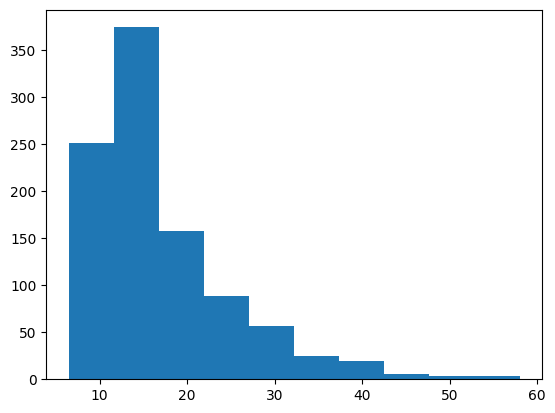

In [43]:
df = pd.read_csv('../ABIDE_Dataset/data/ABIDEI/participants.tsv', sep="\t", dtype=str)
print(sum(df["age"].astype(float))/len(df))

df = pd.read_csv('../ABIDE_Dataset/outputs/ABIDEI/sfcn_age_predictions.csv')
print((sum(df["label"].astype(float)) - sum(df["top_bin"].astype(float)))/len(df))
plt.hist(df.label)

# Fine Tune for ASD vs Non-ASD Class Prediction